# Models Comparison for TinyML

In [18]:
# Load libraries
import numpy as np
from numpy import arange
import pickle
from pandas import read_csv
#
import matplotlib.pyplot as plt

#
import pandas as pd
from pandas import read_csv

from sklearn.metrics import confusion_matrix,  classification_report, f1_score
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder

from keras.models import Sequential, Model 
from keras.layers import Dense, Input, concatenate, Activation, Dropout
from keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import tensorflow
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from micromlgen import port
import tinymlgen as tiny

import warnings
import seaborn as sbs
import sys

warnings.filterwarnings('ignore')

In [19]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tensorflow.random.set_seed(RANDOM_SEED)
np.set_printoptions(threshold=sys.maxsize)

In [20]:
with open('data/X2.pkl', 'rb') as f:
    X = pickle.load(f)

with open('data/y2.pkl', 'rb') as f:
    y = pickle.load(f)

In [21]:
labels = 2
samples = 150
X = X[:labels*samples]
y = y[:labels*samples]

In [22]:
classes = np.unique(y).tolist()
for i in range(len(classes)):
    y = np.where(y==classes[i], i, y)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)

In [24]:
scaler = RobustScaler()

In [25]:
X_test.shape

(60, 32)

In [26]:
y = np.array([int(el) for el in y])
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1]


## Model Spotting

In [27]:
# Test options and evaluation metric
num_folds = 10
seed = 42
scoring = 'f1_macro'

In [28]:
# Spot-Check Algorithms
models = []

#models.append(('XGB', XGBClassifier(random_state=seed)))
models.append(('GNB', GaussianNB(var_smoothing=2e-9)))
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('CART' , DecisionTreeClassifier(random_state=seed)))
models.append(('SVC' , SVC(gamma=0.05, random_state=seed)))
models.append(('RF', RandomForestClassifier(random_state=seed, n_estimators = 50)))


In [29]:
# Cross Validation
results = []
names = []
for name, model in models:
    # Dividere dati in n = num_folds
    kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = np.array([])
    for train_idx, test_idx, in kf.split(X_train, y_train):
        X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
        X_cross_train = scaler.fit_transform(X_cross_train)
        X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
        X_cross_test = scaler.transform(X_cross_test)
        model.fit(X_cross_train, y_cross_train)  
        y_pred = model.predict(X_cross_test)
        f1s = f1_score(y_cross_test, y_pred, average="weighted")
        cv_results = np.append(cv_results, [f1s])
    results.append(cv_results)
    names.append(name)
    #msg = "%s - %f - %f" % (name, cv_results.mean(), cv_results.std())
    msg = "{} - {:.2f} {:.2f}".format(name, cv_results.mean(), cv_results.std()).replace('.', ',')
    print(msg)

GNB - 0,63 0,08
LR - 0,68 0,08
CART - 0,71 0,05
SVC - 0,81 0,06
RF - 0,80 0,06


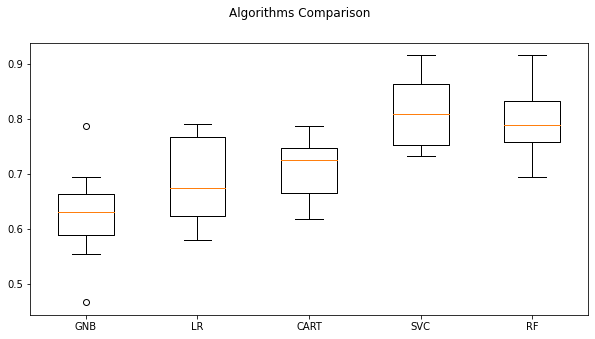

In [30]:
# Compare Algorithms
fig = plt.figure(figsize=(10,5))
fig.suptitle('Algorithms Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Valutazione dei migliori algoritmi su test

## Valutazione modelli sul Test Set

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
for name, model in models:
    model.fit(X_train,  y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print(f"Model {name}: ")
    print(classification_report(y_test, pred_test))
    print("-------------------------------------------------------------")

Model GNB: 
              precision    recall  f1-score   support

           0       0.70      0.87      0.78        30
           1       0.83      0.63      0.72        30

    accuracy                           0.75        60
   macro avg       0.76      0.75      0.75        60
weighted avg       0.76      0.75      0.75        60

-------------------------------------------------------------
Model LR: 
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        30
           1       0.67      0.67      0.67        30

    accuracy                           0.67        60
   macro avg       0.67      0.67      0.67        60
weighted avg       0.67      0.67      0.67        60

-------------------------------------------------------------
Model CART: 
              precision    recall  f1-score   support

           0       0.79      0.77      0.78        30
           1       0.77      0.80      0.79        30

    accuracy          

## Valutazione Inferance Rate medio (|X_test| = 40)

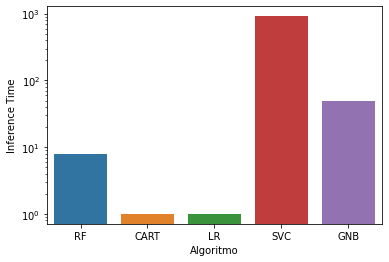

In [15]:
csv = read_csv("InfTimeReport.csv")
g = sbs.barplot(x=csv['Algoritmo'], y=csv['InfTime'])
g.set_yscale("log")
plt.ylabel("Inference Time")
plt.show()

## Memoria occupata

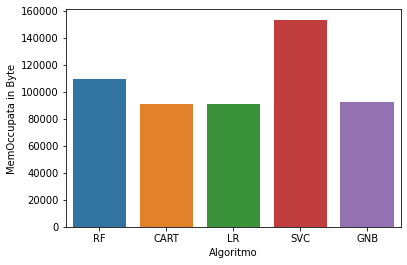

In [16]:
csv = read_csv("MemOccupationReport.csv")
sbs.barplot(x=csv['Algoritmo'], y=csv['MemOccupata2'])
plt.ylabel("MemOccupata in Byte")
plt.show()

# Neural Network

In [32]:
def getNetwork():
    model = Sequential(name="Sequential-NN")
    model.add(layers.Dense(X.shape[1], activation='relu', input_shape=(X.shape[1],)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(np.unique(y).size, activation='softmax'))
    opt = Adam(learning_rate=0.0001)
    # SGB
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

## Cross Validation NN

In [27]:
EPOCHS = 500
BATCH_SIZE = 8
num_folds = 10


kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
cv_results = np.array([])
for train_idx, test_idx, in kf.split(X_train, y_train):
    X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
    X_cross_train = scaler.fit_transform(X_cross_train)
    X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
    X_cross_test = scaler.transform(X_cross_test)
    model = getNetwork()
    model.fit(X_cross_train, y_cross_train, epochs=EPOCHS, batch_size=BATCH_SIZE)  
    y_pred = model.predict(X_cross_test)
    predictions_categorical = np.argmax(y_pred, axis=1)
    f1s = f1_score(y_cross_test, predictions_categorical, average="weighted")
    cv_results = np.append(cv_results, [f1s])

print(f'Average score of Cross Validation: {cv_results.mean()}')

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 3,363
Trainable params: 3,363
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
41/41 [==============================] - 0s 496us/step - loss: 1.1479 - accuracy: 0.3241
Epoch 2/500
41/4

Epoch 151/500
41/41 [==============================] - 0s 507us/step - loss: 0.6965 - accuracy: 0.7377
Epoch 152/500
41/41 [==============================] - 0s 527us/step - loss: 0.7071 - accuracy: 0.6975
Epoch 153/500
41/41 [==============================] - 0s 518us/step - loss: 0.7048 - accuracy: 0.6975
Epoch 154/500
41/41 [==============================] - 0s 498us/step - loss: 0.6796 - accuracy: 0.7346
Epoch 155/500
41/41 [==============================] - 0s 484us/step - loss: 0.6799 - accuracy: 0.7253
Epoch 156/500
41/41 [==============================] - 0s 505us/step - loss: 0.6624 - accuracy: 0.7222
Epoch 157/500
41/41 [==============================] - 0s 533us/step - loss: 0.6628 - accuracy: 0.7346
Epoch 158/500
41/41 [==============================] - 0s 495us/step - loss: 0.6924 - accuracy: 0.7099
Epoch 159/500
41/41 [==============================] - 0s 484us/step - loss: 0.6787 - accuracy: 0.7099
Epoch 160/500
41/41 [==============================] - 0s 465us/step - lo

KeyboardInterrupt: 

## Train and Test

In [42]:
EPOCHS = 500
BATCH_SIZE = 8
model = getNetwork()
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.25)

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 130       
Total params: 3,298
Trainable params: 3,298
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
23/23 [==============================] - 0s 3ms/step - loss: 0.7564 - accuracy: 0.5056 - val_loss: 0.6723

23/23 [==============================] - 0s 941us/step - loss: 0.5582 - accuracy: 0.7278 - val_loss: 0.6139 - val_accuracy: 0.6833
Epoch 52/500
23/23 [==============================] - 0s 933us/step - loss: 0.5425 - accuracy: 0.7500 - val_loss: 0.6145 - val_accuracy: 0.6667
Epoch 53/500
23/23 [==============================] - 0s 952us/step - loss: 0.5584 - accuracy: 0.7500 - val_loss: 0.6131 - val_accuracy: 0.6667
Epoch 54/500
23/23 [==============================] - 0s 918us/step - loss: 0.5709 - accuracy: 0.6944 - val_loss: 0.6113 - val_accuracy: 0.6833
Epoch 55/500
23/23 [==============================] - 0s 906us/step - loss: 0.5462 - accuracy: 0.7778 - val_loss: 0.6120 - val_accuracy: 0.6833
Epoch 56/500
23/23 [==============================] - 0s 959us/step - loss: 0.5565 - accuracy: 0.7389 - val_loss: 0.6101 - val_accuracy: 0.6833
Epoch 57/500
23/23 [==============================] - 0s 938us/step - loss: 0.5379 - accuracy: 0.7722 - val_loss: 0.6062 - val_accuracy: 0.6833
Epoch

Epoch 165/500
23/23 [==============================] - 0s 943us/step - loss: 0.3877 - accuracy: 0.8389 - val_loss: 0.5770 - val_accuracy: 0.7167
Epoch 166/500
23/23 [==============================] - 0s 919us/step - loss: 0.3958 - accuracy: 0.8222 - val_loss: 0.5752 - val_accuracy: 0.7167
Epoch 167/500
23/23 [==============================] - 0s 947us/step - loss: 0.4147 - accuracy: 0.8333 - val_loss: 0.5761 - val_accuracy: 0.7167
Epoch 168/500
23/23 [==============================] - 0s 948us/step - loss: 0.3839 - accuracy: 0.8333 - val_loss: 0.5806 - val_accuracy: 0.7167
Epoch 169/500
23/23 [==============================] - 0s 926us/step - loss: 0.3840 - accuracy: 0.8333 - val_loss: 0.5802 - val_accuracy: 0.7167
Epoch 170/500
23/23 [==============================] - 0s 984us/step - loss: 0.3748 - accuracy: 0.8556 - val_loss: 0.5801 - val_accuracy: 0.7167
Epoch 171/500
23/23 [==============================] - 0s 990us/step - loss: 0.3824 - accuracy: 0.8222 - val_loss: 0.5797 - val_ac

23/23 [==============================] - 0s 915us/step - loss: 0.3202 - accuracy: 0.8500 - val_loss: 0.5975 - val_accuracy: 0.7000
Epoch 278/500
23/23 [==============================] - 0s 955us/step - loss: 0.3551 - accuracy: 0.8667 - val_loss: 0.5996 - val_accuracy: 0.7000
Epoch 279/500
23/23 [==============================] - 0s 956us/step - loss: 0.3472 - accuracy: 0.8278 - val_loss: 0.5981 - val_accuracy: 0.7000
Epoch 280/500
23/23 [==============================] - 0s 1ms/step - loss: 0.3298 - accuracy: 0.8667 - val_loss: 0.6034 - val_accuracy: 0.7000
Epoch 281/500
23/23 [==============================] - 0s 922us/step - loss: 0.3082 - accuracy: 0.8722 - val_loss: 0.6032 - val_accuracy: 0.7000
Epoch 282/500
23/23 [==============================] - 0s 941us/step - loss: 0.2815 - accuracy: 0.8889 - val_loss: 0.6023 - val_accuracy: 0.7000
Epoch 283/500
23/23 [==============================] - 0s 935us/step - loss: 0.2887 - accuracy: 0.8833 - val_loss: 0.5972 - val_accuracy: 0.7000
E

Epoch 334/500
23/23 [==============================] - 0s 918us/step - loss: 0.2834 - accuracy: 0.9000 - val_loss: 0.6054 - val_accuracy: 0.7000
Epoch 335/500
23/23 [==============================] - 0s 936us/step - loss: 0.3137 - accuracy: 0.8556 - val_loss: 0.6061 - val_accuracy: 0.7000
Epoch 336/500
23/23 [==============================] - 0s 911us/step - loss: 0.2809 - accuracy: 0.8722 - val_loss: 0.6026 - val_accuracy: 0.7000
Epoch 337/500
23/23 [==============================] - 0s 898us/step - loss: 0.2736 - accuracy: 0.9000 - val_loss: 0.6024 - val_accuracy: 0.7000
Epoch 338/500
23/23 [==============================] - 0s 958us/step - loss: 0.2832 - accuracy: 0.8778 - val_loss: 0.6002 - val_accuracy: 0.7000
Epoch 339/500
23/23 [==============================] - 0s 945us/step - loss: 0.3160 - accuracy: 0.8556 - val_loss: 0.5992 - val_accuracy: 0.7000
Epoch 340/500
23/23 [==============================] - 0s 916us/step - loss: 0.2800 - accuracy: 0.9111 - val_loss: 0.5997 - val_ac

Epoch 447/500
23/23 [==============================] - 0s 949us/step - loss: 0.2823 - accuracy: 0.8889 - val_loss: 0.6245 - val_accuracy: 0.7000
Epoch 448/500
23/23 [==============================] - 0s 936us/step - loss: 0.2636 - accuracy: 0.9111 - val_loss: 0.6308 - val_accuracy: 0.7000
Epoch 449/500
23/23 [==============================] - 0s 921us/step - loss: 0.2413 - accuracy: 0.9000 - val_loss: 0.6308 - val_accuracy: 0.7000
Epoch 450/500
23/23 [==============================] - 0s 951us/step - loss: 0.2657 - accuracy: 0.8833 - val_loss: 0.6356 - val_accuracy: 0.7000
Epoch 451/500
23/23 [==============================] - 0s 918us/step - loss: 0.2516 - accuracy: 0.9000 - val_loss: 0.6410 - val_accuracy: 0.6833
Epoch 452/500
23/23 [==============================] - 0s 944us/step - loss: 0.2270 - accuracy: 0.9333 - val_loss: 0.6513 - val_accuracy: 0.6833
Epoch 453/500
23/23 [==============================] - 0s 970us/step - loss: 0.2713 - accuracy: 0.8944 - val_loss: 0.6519 - val_ac

In [43]:
pred_test = model.predict(X_test)
predictions_categorical = np.argmax(pred_test, axis=1)
print(classification_report(y_test, predictions_categorical))

              precision    recall  f1-score   support

           0       0.75      0.80      0.77        30
           1       0.79      0.73      0.76        30

    accuracy                           0.77        60
   macro avg       0.77      0.77      0.77        60
weighted avg       0.77      0.77      0.77        60



# Export Models in C code

In [44]:
# Neural network with TinyMLGen
with open('exportedModels/NNmodel.h', 'w') as f:
    f.write(tiny.port(model, optimize=False))

# Classifiers with MicroMLGen
for name, model in models:
    prepath = 'exportedModels/' + str(labels) + "/"
    path = prepath + name + '.h'
    x = port(model, optimize=True)
    with open(path, 'w') as f:
        f.write(port(model, optimize=True))

INFO:tensorflow:Assets written to: /tmp/tmppmjwyglg/assets


INFO:tensorflow:Assets written to: /tmp/tmppmjwyglg/assets
